In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import glob
import numpy as np
import pandas as pd

from facerecognition.inference import FaceRecognition
from spoofing.inference import Spoofing
from facerecognition.utils import (get_frames, find_largest_bbox_index)
from spoofing.metrics import (calculate_eer, calculate_far_frr,
                              evaluate_model, plot_roc, plot_recall_far)

In [3]:
def get_frame_videos(folder, frame_skip=10):
    """
    Extracts frames from video files in a specified folder, skipping a specified number of frames.

    Parameters:
    folder (str): The path to the folder containing the video files.
    frame_skip (int): The number of frames to skip between each frame extraction. Default is 10.

    Returns:
    dict: A dictionary where the keys are the video names (without extension) and the values are lists of extracted frames.
    """
    video_frames = {}
    for video_path in glob.glob(os.path.join(folder, '*.mp4')):
        video_name = os.path.basename(video_path).split('.')[0]
        video_frames[video_name] = get_frames(video_path, frame_skip=frame_skip)
    return video_frames

def get_spoofing_value(videos):
    """
    Evaluates the spoofing value for faces detected in frames of the given videos.

    Parameters:
    videos (dict): A dictionary where the keys are video names and the values are lists of frames from the videos.

    Returns:
    list: A list of dictionaries, each containing:
          - 'video_name': The name of the video.
          - 'i': The frame index.
          - 'value': The spoofing evaluation value for the detected face.
    """
    values = []
    for video_names, frames in videos.items():
        for i, frame in enumerate(frames):
            faces, bboxes = face_recognition.detect_faces(frame)
            if len(bboxes) > 0:
                posic = find_largest_bbox_index(bboxes)
                values.append({
                    'video_name': video_names,
                    'i': int(i),
                    'value': anti_spoofing.eval_spoofing(frame, bboxes[posic])
                })
    return values


### Instance classes construtor

In [5]:
face_recognition = FaceRecognition(image_size=160, margin=0,
                                   min_face_size=20, thresholds=[0.6, 0.7, 0.7],
                                   factor=0.709, post_process=True)
anti_spoofing = Spoofing(model_dir='spoofing/anti_spoof_models')

### Read frames from videos

In [6]:
fake_videos = get_frame_videos('data/videos/fake')
real_videos = get_frame_videos('data/videos/real')

### Extract the spoofing values

In [18]:
fake_values = get_spoofing_value(fake_videos)
real_values = get_spoofing_value(real_videos)

In [19]:
fake_df = pd.DataFrame(fake_values)
real_df = pd.DataFrame(real_values)
fake_df['label'] = 'fake'
real_df['label'] = 'real'

result = pd.concat([fake_df, real_df])
result.to_csv("data/results/spoofing_prediction.csv", index=False)

## Calculate metrics

In [20]:
y_true = np.array(result['label'] == 'fake')
y_scores = np.array(result['value'])

In [21]:
thresholds = np.linspace(min(y_scores), max(y_scores), num=100)
far, frr = calculate_far_frr(y_true, y_scores, thresholds)
eer, best_threshold, posic = calculate_eer(far, frr, thresholds)


# Calculate additional metrics
auc_roc, precision, recall, f1, accuracy = evaluate_model(y_true, y_scores, best_threshold)

print(f'EER: {eer}')
print(f'FAR: {far[posic]}, FRR: {frr[posic]}, Recall: {1-frr[posic]}')
print(f'Best Threshold: {best_threshold}')

print(f'AUC-ROC: {auc_roc}')
print(f'Precision: {precision}, Recall {recall}')
print(f'F1-Score: {f1}, Accuracy {accuracy}')


EER: 0.06090365988681845
FAR: 0.0657769304099142, FRR: 0.0560303893637227, Recall: 0.9439696106362773
Best Threshold: 0.9798
AUC-ROC: 0.984328221061618
Precision: 0.9350893697083725, Recall 0.9439696106362773
F1-Score: 0.9395085066162571, Accuracy 0.9391056137012369


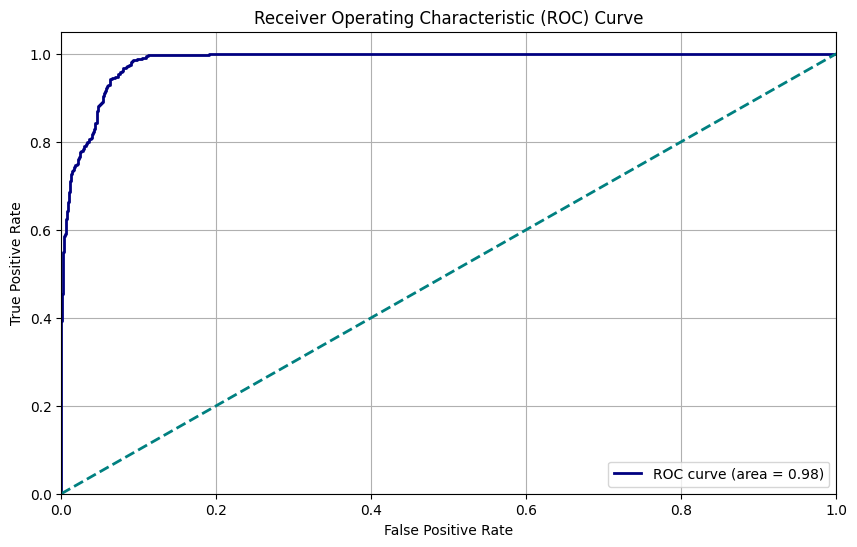

In [24]:
plot_roc(y_true, y_scores, 'data/results/roc_spoofing.png')

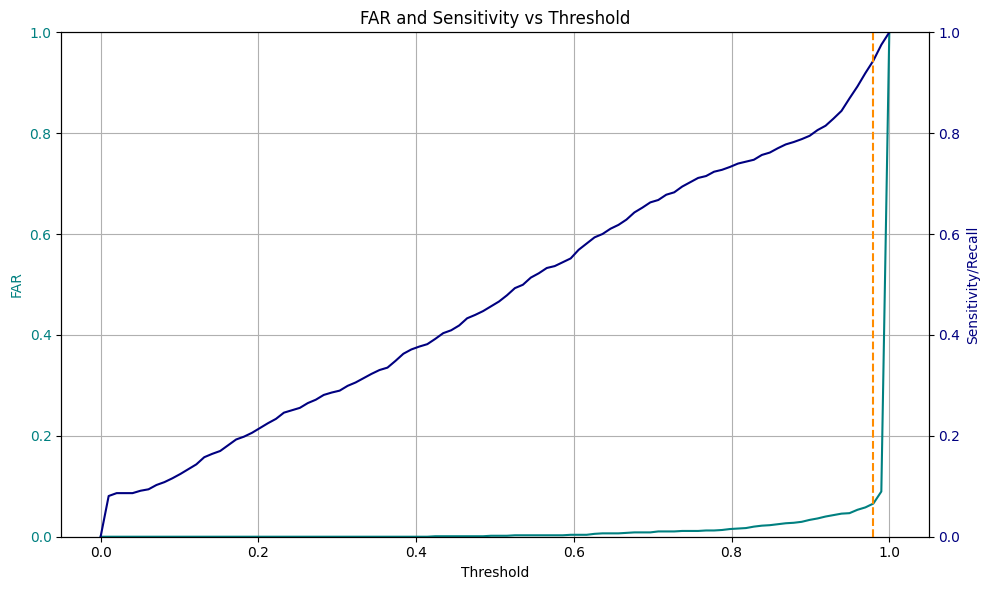

In [23]:
plot_recall_far(far, frr, thresholds, best_threshold, 'data/results/far_recall_spoofing.png')